In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from capstone.util import load_kospi_data, load_dataset
import os
import warnings

from matplotlib import ticker
warnings.filterwarnings(action='ignore')
import networkx as nx
import community as community_louvain

In [2]:
pickle_path = './pickle'
kospi_path = './data/kospi200_stocks.xlsx'

interest_rate_increase = {
    "name" : 'interest_rate_increase',
    "start_date" : '2020-01-01',
    "end_date": '2022-03-01'
}
yield_curve_inversion = {
    "name" : "yield_curve_inversion",
    "start_date" : '2018-01-01',
    "end_date": '2019-12-01'
}

In [3]:
kospi_pickle_path = pickle_path + '/kospi_data.pickle'
kospi_data = load_kospi_data(kospi_pickle_path,kospi_path)
interest_rate_pickle_path = pickle_path + f'/{interest_rate_increase["name"]}.pickle'
yield_curve_pickle_path = pickle_path + f'/{yield_curve_inversion["name"]}.pickle'

In [4]:
# df_interest_rate = load_dataset(kospi_data,interest_rate_pickle_path,interest_rate_increase['start_date'],interest_rate_increase['end_date'])
# tmp = df_interest_rate

df_yield_curve = load_dataset(kospi_data,yield_curve_pickle_path,yield_curve_inversion['start_date'],yield_curve_inversion['end_date'])
tmp = df_yield_curve

In [5]:
# yield curve increase
test_df = tmp[:'2019-01-01']
validation_df = tmp['2019-01-02':]

In [6]:
from modularity.calculate_modularity import calculate_louvain
from community import community_louvain

partition,G = calculate_louvain(test_df,threshold=0.15)
modularity_value = community_louvain.modularity(partition,G)
print(f"MODULARITY : {modularity_value}")

MODULARITY : 0.10563987636177105


In [7]:
n_clusters = len(set(partition.values()))
print(f"클러스터 갯수 : {n_clusters}")

# 클러스터 개수만큼 딕셔너리 생성
dict_clusters = {i : [] for i in range(n_clusters)}

클러스터 갯수 : 2


In [8]:
# 클러스터 기준으로 군집 분류 
for stock_code,cluster in partition.items():
    dict_clusters[cluster].append(stock_code)

In [9]:
# 각 군집별로 데이터프레임 생성
clusters_list = []
for cluster in dict_clusters.keys():
    clusters_list.append(tmp[dict_clusters[cluster]])

In [10]:
# validation 각 군집별로 데이터프레임 생성
val_clusters_list = []
for cluster in dict_clusters.keys():
    val_clusters_list.append(validation_df[dict_clusters[cluster]])

In [11]:
clusters_list

[Code       A005930 A000660 A207940 A003670 A000810 A033780 A011200 A017670  \
 Date                                                                         
 2018-01-01   50960   76500  366658   37357  267000  115500    5020   46067   
 2018-01-02   51020   76600  384941   38014  265500  115000    5010   45808   
 2018-01-03   51620   77700  386424   37028  265500  111500    4790   45205   
 2018-01-04   51080   77100  378518   35573  262500  112000    4625   44773   
 2018-01-05   52120   79300  385436   38295  260500  109000    4635   46153   
 ...            ...     ...     ...     ...     ...     ...     ...     ...   
 2019-11-27   52200   82700  392354   45804  238500   97900    3580   42271   
 2019-11-28   51300   82800  394330   45992  240000   98700    3565   42530   
 2019-11-29   50300   80900  388895   45147  232500   97800    3610   42444   
 2019-11-30   50300   80900  388895   45147  232500   97800    3610   42444   
 2019-12-01   50300   80900  388895   45147  232500 

In [12]:
import statsmodels.api as sm

def make_top_20_all_clusters(clusters_list:list)->list:
    top_20_stocks = {}

    # 각 클러스터 별로 K-ratio 계산 및 랭킹 매기기  
    for idx, df_cluster in enumerate(clusters_list):
        # 종목 코드 리스트
        ticker_list = df_cluster.columns

        # 일별 수익률 계산
        returns = df_cluster.pct_change().iloc[1:]
        # 누적 로그 수익률 
        cum_returns = np.log(1 + returns).cumsum()
        # X축 : 기간 
        x = np.array(range(len(returns)))
        K_ratio = {}

        for ticker in ticker_list:
            try:
                y = cum_returns[ticker].values
                # OLS 회귀 분석
                reg = sm.OLS(y, sm.add_constant(x)).fit()
                # K- ratio
                result = float(reg.params[1] / reg.bse[1])
            except:
                result = np.nan
            K_ratio[ticker] = result

        # K-ratio를 데이터 프레임으로 변환
        df_k_ratio = pd.DataFrame.from_dict(K_ratio, orient='index').reset_index()
        df_k_ratio.columns = ['종목코드', 'K_ratio']

        # K-ratio에 따라 종목을 랭킹 
        df_k_ratio['K_ratio_rank'] = df_k_ratio['K_ratio'].rank(axis=0, ascending=False)
        # 상위 n개 종목 추출(10,20,30) 
        top_20 = df_k_ratio[df_k_ratio['K_ratio_rank'] <= 10]
        top_20_stocks[f'cluster_{idx}'] = top_20

    top_20_all_clusters = []
    for cluster_df in top_20_stocks.values():
        top_20_all_clusters.extend(cluster_df['종목코드'].tolist())

    top_20_all_clusters = list(set(top_20_all_clusters))
    return top_20_all_clusters

In [13]:
# 상위 n개의 종목을 합치고 중복을 제거
top_20_all_clusters = make_top_20_all_clusters(clusters_list)

# dataset_1st_year에서 상위 n개 종목들만 추출 
df_momentum = tmp[top_20_all_clusters]

In [14]:
#상위 n개 종목의 모멘텀 나누기


# yield curve
test_df = df_momentum[:'2019-01-01']
validation_df = df_momentum['2019-01-02':]


In [15]:
test_df_pct = test_df.pct_change().dropna()
mean_returns = test_df_pct.mean()
cov_matrix = test_df_pct.cov()

In [16]:
validation_df_pct = validation_df.pct_change().dropna()

In [17]:
from capstone.portfolio_model import mean_variance_portfolio
weight = mean_variance_portfolio(mean_returns, cov_matrix)
weight

array([0.00000000e+00, 1.70088943e-12, 6.22904506e-14, 6.68978761e-14,
       4.27921587e-14, 8.19899704e-14, 1.00000000e+00, 3.41816853e-13,
       2.20899687e-13, 2.98677749e-13, 2.35367281e-14, 3.23331639e-13,
       1.43392243e-13, 1.71911096e-13, 2.67799671e-13, 1.17433840e-13,
       2.15508167e-13, 0.00000000e+00, 2.55302723e-13, 3.05748482e-13])

In [18]:
result = validation_df_pct @ weight

In [19]:
df_profit_accumulate = (1+result).cumprod()-1

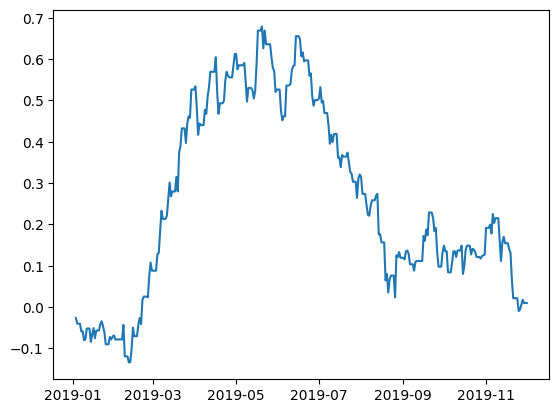

In [20]:
plt.plot(df_profit_accumulate)
plt.savefig('./fig/m_m_m_interestRate.png', format='png', dpi=300)

In [21]:
from capstone.util import make_benchmark_kospi200

benchmark_kospi_202001_202203 = make_benchmark_kospi200('./pickle/202001_202203_KOSPI_200.pickle','2020-01-01','2022-03-01')
benchmark_kospi_201801_201912 = make_benchmark_kospi200('./pickle/201801_201912_KOSPI_200.pickle','2018-01-01','2019-12-01')

In [22]:
from capstone.util import make_cumulative_return

cum_202001_202203 = make_cumulative_return('./pickle/202001_202203_CUM_KOSPI_200.pickle',benchmark_kospi_202001_202203)
cum_201801_201912 = make_cumulative_return('./pickle/201801_201912_CUM_KOSPI_200.pickle',benchmark_kospi_201801_201912)


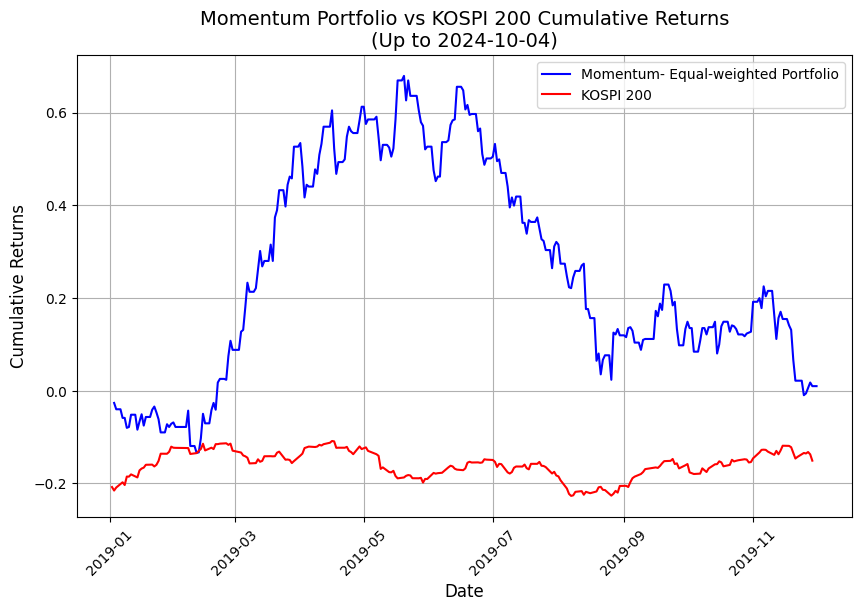

In [24]:
from capstone.util import compare_with_benchmark

compare_with_benchmark(df_profit_accumulate,cum_201801_201912['2019-01-02':],'2019-01-02','2019-12-01')